# Imformation

Colunas
- Gender: Gênero do cliente
- Age: Idade do cliente
- Type of Purchase: O tipo de compra
- Store size: O tamanho da loja
- Store distance: Distância até o centro da cidade
- InStore wifi: Nível de satisfação com o Wifi da Loja
- Open/Close time convenient: Nível de satisfação do horário de abertura e fechamento da loja
- Easy of online shopping: Nível de satisfação com a compra online
- Store location: Nível de satisfação com a acesso a loja
- Toilet cleaning:Nível de limpeza dos banheiros
- Dressing room: Nível de satisfação com o provador
- Waiting room: Nível de satisfação do local de espera dentro da loja.
- Kids entertainment: Nível de satisfação do espaço kids
- Seller service: Nível de satisfação com o atendimento dos vendedores
- Showroom: Nível de satisfação com a disposição das roupas no interior da loja
- Self-Store: Nível de satisfação com os guarda-volumes da loja
- Purchase service: Nível de satisfação do atendimento no pagamento
- Inflights Service: Store Service
- Cleanliness: Nível de satisfação com a limpeza da loja
- Carrier delay in minutes: Tempo de atraso do produto na saída da transportadora
- Delivery delay in minutes: Tempo de atraso na entrega do produto até a casa do cliente.

# 0. Imports and Help Functions

## 0.1 Imports

In [150]:
import inflection
import random

import pandas     as pd
import numpy      as np
import scikitplot as skplt
import seaborn    as sns
import sweetviz   as sv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import RobustScaler, LabelEncoder
from sklearn.ensemble        import RandomForestClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import LinearSVC
from sklearn.naive_bayes     import GaussianNB
from sklearn.metrics         import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score
from xgboost                 import XGBClassifier

from matplotlib import pyplot as plt

## 0.2 Data Load

In [3]:
df_raw_train = pd.read_csv('dataset/train.csv')
df_raw_test = pd.read_csv('dataset/test.csv')

In [4]:
df_raw_train.head()

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,...,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,Satisfied


## 0.3 Helper Functions

In [5]:
def metrics(y, yhat):
    precision, recall, thresholds = precision_recall_curve(y, yhat[:,1])    
    
    plt.subplot(1, 2, 1)
    plt.plot(precision, recall, marker='o')
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot( thresholds, precision[:-1], 'b--', label='Precision' );
    plt.plot( thresholds, recall[:-1], 'g-', label='Recall' );
    plt.xlabel( 'Thresholds' );
    plt.ylabel( 'Precison, Recall' );
    plt.legend()
    plt.grid()

    sns.set(rc={'figure.figsize':(10,5)})    
    
    skplt.metrics.plot_cumulative_gain(y, yhat)
    skplt.metrics.plot_lift_curve(y, yhat)
    
    sns.set(rc={'figure.figsize':(10,3)})    

    # Calculate ROC curve values
    fpr, tpr, thresholds = roc_curve(y, yhat[:, 1])
    # Calculate AUC score
    auc_score = roc_auc_score(y, yhat[:, 1])

    # Find the best threshold based on ROC curve
    distances = np.sqrt((1 - tpr)**2 + fpr**2)
    best_threshold = thresholds[np.argmin(distances)]
    
    # Calculate Accuracy Score
    yhat_thresh = np.where(yhat[:, 1] > best_threshold, 1, 0)
    acs = average_precision_score(y, yhat_thresh)
    
    return print(f"Best Threshold: {best_threshold}, Accuracy Score: {acs:.4f}")

# 1. Data Description

In [6]:
df1 = df_raw_train.copy()

## 1.1 Rename Columns

In [7]:
new_columns = ['id', 'gender', 'customer_type', 'age', 'type_of_purchase',
               'store_size', 'store_distance', 'in_store_wifi',
               'open/close_time_convenient', 'easy_of_online_shopping',
               'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
               'kids_entertainment', 'seller_service', 'showroom', 'self_store',
               'purchase_service', 'store_service', 'cleanliness',
               'carrier_delay_in_minutes', 'delivery_delay_in_minutes',
               'satisfaction']
df1.columns = new_columns

df1.head()

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,...,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,Satisfied


## 1.2 Data Dimensions

In [8]:
print("Linhas: {}".format(df1.shape[0]))
print("Colunas: {}".format(df1.shape[1]))

Linhas: 103904
Colunas: 24


## 1.3 Data Dtypes

In [9]:
df1.dtypes

id                              int64
gender                         object
customer_type                  object
age                             int64
type_of_purchase               object
store_size                     object
store_distance                  int64
in_store_wifi                   int64
open/close_time_convenient      int64
easy_of_online_shopping         int64
store_location                  int64
toilet_cleaning                 int64
dressing_room                   int64
waiting_room                    int64
kids_entertainment              int64
seller_service                  int64
showroom                        int64
self_store                      int64
purchase_service                int64
store_service                   int64
cleanliness                     int64
carrier_delay_in_minutes        int64
delivery_delay_in_minutes     float64
satisfaction                   object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

id                              0
gender                          0
customer_type                   0
age                             0
type_of_purchase                0
store_size                      0
store_distance                  0
in_store_wifi                   0
open/close_time_convenient      0
easy_of_online_shopping         0
store_location                  0
toilet_cleaning                 0
dressing_room                   0
waiting_room                    0
kids_entertainment              0
seller_service                  0
showroom                        0
self_store                      0
purchase_service                0
store_service                   0
cleanliness                     0
carrier_delay_in_minutes        0
delivery_delay_in_minutes     310
satisfaction                    0
dtype: int64

## 1.5 Fillout NA

In [11]:
df1.head()

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,...,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,Satisfied


In [12]:
df1[df1['delivery_delay_in_minutes'].isna()].sample(5)

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,...,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction
56039,43942,Male,Loyal Customer,16,Personal,Small,199,3,5,0,...,5,5,3,5,3,5,5,4,NaN,Neutral or Dissatisfaction
2630,3638,Male,Loyal Customer,35,Gift,Large,1534,1,1,1,...,5,5,5,5,5,5,5,0,NaN,Satisfied
52676,57746,Male,Loyal Customer,45,Gift,Large,2611,3,3,3,...,4,4,4,4,3,4,5,8,NaN,Satisfied
60367,112231,Female,Loyal Customer,33,Personal,Small,1199,2,1,1,...,2,1,3,3,1,3,2,4,NaN,Neutral or Dissatisfaction
45307,74356,Female,Loyal Customer,47,Gift,Large,1171,2,2,2,...,2,2,2,2,4,2,5,0,NaN,Satisfied


In [13]:
# Se a não há tempo de carrier_delay, pode significar que a compra foi presencial
# Caso seja online, adicionar a média de tempo de entrega

med = np.round(df1['delivery_delay_in_minutes'].mean())
df1['delivery_delay_in_minutes'] = df1.apply(lambda x: 
                                            x['delivery_delay_in_minutes'] if pd.notna(x['delivery_delay_in_minutes']) else
                                            0 if x['carrier_delay_in_minutes'] == 0 else med, axis = 1)


In [14]:
df1.isna().sum()

id                            0
gender                        0
customer_type                 0
age                           0
type_of_purchase              0
store_size                    0
store_distance                0
in_store_wifi                 0
open/close_time_convenient    0
easy_of_online_shopping       0
store_location                0
toilet_cleaning               0
dressing_room                 0
waiting_room                  0
kids_entertainment            0
seller_service                0
showroom                      0
self_store                    0
purchase_service              0
store_service                 0
cleanliness                   0
carrier_delay_in_minutes      0
delivery_delay_in_minutes     0
satisfaction                  0
dtype: int64

## 1.6 Charge Types

In [15]:
# Charge delivery_delay_in_minutes type from int
df1['delivery_delay_in_minutes'] = df1['delivery_delay_in_minutes'].astype(np.int64())

## 1.7 Descriptive Statistical

In [16]:
df_num = df1.select_dtypes(include=['int64', 'float64'])
df_cat = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.7.1 Numerical Atributes

In [17]:
df_num.describe()

,id,age,store_distance,in_store_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.161399
std,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.644234
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [18]:
d1 = pd.DataFrame (df_num.min()).T
d2 = pd.DataFrame (df_num.max()).T
d3 = pd.DataFrame (df_num.max() - df_num.min()).T
d4 = pd.DataFrame (df_num.mean()).T
d5 = pd.DataFrame (df_num.median()).T
d6 = pd.DataFrame (df_num.std()).T
d7 = pd.DataFrame (df_num.skew()).T
d8 = pd.DataFrame (df_num.kurt()).T

df_num = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8]).T.reset_index()
df_num.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'skewness', 'kurtosis']

df_num

,attributes,min,max,range,mean,median,standard_deviation,skewness,kurtosis
0,id,1.0,129880.0,129879.0,64924.210502,64856.5,37463.812252,0.002864,-1.198440
1,age,7.0,85.0,78.0,39.379706,40.0,15.114964,-0.004516,-0.719568
2,store_distance,31.0,4983.0,4952.0,1189.448375,843.0,997.147281,1.109466,0.268535
3,in_store_wifi,0.0,5.0,5.0,2.729683,3.0,1.327829,0.040408,-0.846170
4,open/close_time_convenient,0.0,5.0,5.0,3.060296,3.0,1.525075,-0.334399,-1.037767
5,easy_of_online_shopping,0.0,5.0,5.0,2.756901,3.0,1.398929,-0.018294,-0.910346
6,store_location,0.0,5.0,5.0,2.976883,3.0,1.277621,-0.058889,-1.030283
7,toilet_cleaning,0.0,5.0,5.0,3.202129,3.0,1.329533,-0.151279,-1.145453
8,dressing_room,0.0,5.0,5.0,3.250375,3.0,1.349509,-0.453852,-0.702006
9,waiting_room,0.0,5.0,5.0,3.439396,4.0,1.319088,-0.482775,-0.925702


### 1.7.2 Categorical Atributes

In [19]:
df_cat.head()

,gender,customer_type,type_of_purchase,store_size,satisfaction
0,Male,Loyal Customer,Personal,Small,Neutral or Dissatisfaction
1,Male,disloyal Customer,Gift,Large,Neutral or Dissatisfaction
2,Female,Loyal Customer,Gift,Large,Satisfied
3,Female,Loyal Customer,Gift,Large,Neutral or Dissatisfaction
4,Male,Loyal Customer,Gift,Large,Satisfied


In [20]:
# Gender
df_cat[['gender', 'customer_type']].groupby('gender').count().reset_index()

,gender,customer_type
0,Female,52727
1,Male,51177


In [21]:
# Customer Type
df_cat[['gender', 'customer_type']].groupby('customer_type').count().reset_index()

,customer_type,gender
0,Loyal Customer,84923
1,disloyal Customer,18981


In [22]:
# Type of Purchase
df_cat[['type_of_purchase', 'gender']].groupby('type_of_purchase').count().reset_index()

,type_of_purchase,gender
0,Gift,71655
1,Personal,32249


In [23]:
# Store Size
df_cat[['store_size', 'gender']].groupby('store_size').count().reset_index()

,store_size,gender
0,Large,49665
1,Medium,46745
2,Small,7494


In [24]:
# satisfaction
df_cat[['satisfaction', 'gender']].groupby('satisfaction').count().reset_index()

,satisfaction,gender
0,Neutral or Dissatisfaction,58879
1,Satisfied,45025


# 2. Feature Engineering

In [25]:
df2 = df1.copy()

## 2.1 FlipBook

| Aspecto | Descrição | Opções | Exemplos |  |
| --- | --- | --- | --- | --- |
| Canal de Aquisição | Como o visitante, cliente ou usuário encontra sobre a sua empresa. | Anúncios Pagos | Anúncios Patrocinados do Google |  |
|  |  | Motor de Busca | Buscar orgânicas, aquelas que não são pagas para aparecer. Ex. pesquisas do google. |  |
|  |  | Redes sociais | Anúncios no Instagram, Facebook, etc. |  |
|  |  | Lojas | Pontos Físicos |  |
| Táticas de Vendas | O que a sua empresa faz para convencer o visitante ou usuário a se tornar um cliente. | Compra única. | Compra individual de um produto ( Mercado ). |  |
|  |  | Descontos e incentivos | x% de desconto, compre x e leve y, segunda unidade com x% de desconto. |  |
| Modelo de Receita | Como a empresa faz dinheiro dos seus visitantes usuários ou clientes | Compra uma única vez | Casas, apartamentos por exemplo |  |
| Tipo de Produto | O que a sua empresa faaz em troca do valor monetário. Podem ser produtos ou serviços. | Revenda de produtos |  |  |
| Modelo de Entrega | Como o produto chega ao cliente | Entrega Física |  |  |

## 2.2 Feature Engineering

In [26]:
# Online/in person purchase
df2['online_purchase'] = df2['delivery_delay_in_minutes'].apply(lambda x: 0 if x == 0 else 1 )

# 3. Columns Selection

In [27]:
df3 = df2.copy()

# 4. Exploratory data Analysis

In [28]:
df4 = df3.copy()

## 4.1 sv.analyze

In [29]:
# report = sv.analyze(df4)
# report.show_html('report.html')

## 4.2 Univariate Analysis

### 4.2.1 Numerical

In [30]:
df_num = df4.select_dtypes(include=['int64', 'float64'])

In [31]:
df_num.columns

Index(['id', 'age', 'store_distance', 'in_store_wifi',
       'open/close_time_convenient', 'easy_of_online_shopping',
       'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
       'kids_entertainment', 'seller_service', 'showroom', 'self_store',
       'purchase_service', 'store_service', 'cleanliness',
       'carrier_delay_in_minutes', 'delivery_delay_in_minutes',
       'online_purchase'],
      dtype='object')

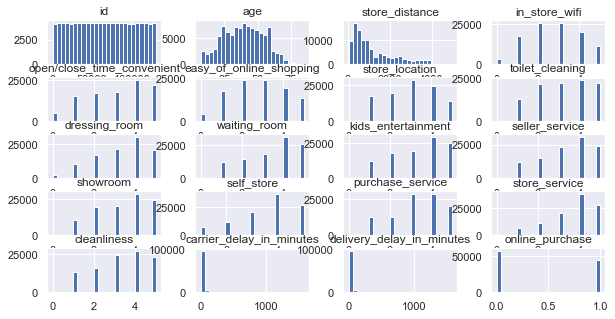

In [32]:
sns.set(rc={'figure.figsize':(10,5)})
df_num.hist(bins=25);

<AxesSubplot:xlabel='age', ylabel='Count'>

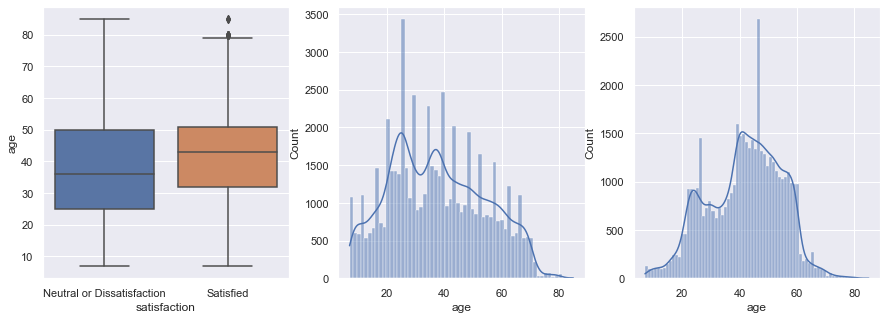

In [33]:
sns.set(rc={'figure.figsize':(15,5)})

# age
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='age')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'age']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'age']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='store_distance', ylabel='Count'>

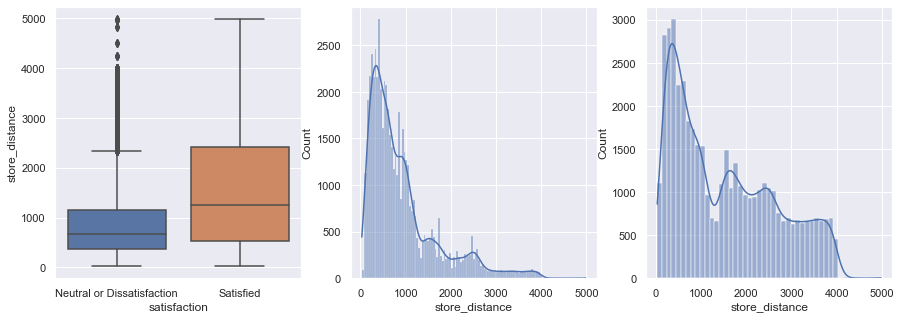

In [34]:
sns.set(rc={'figure.figsize':(15,5)})

# Store Distance
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='store_distance')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'store_distance']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'store_distance']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='in_store_wifi', ylabel='Count'>

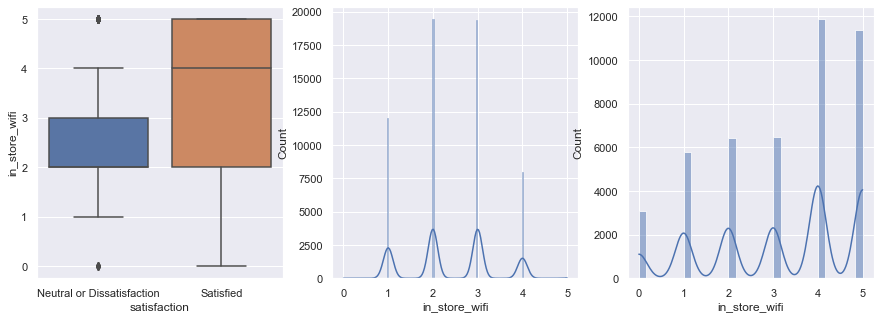

In [35]:
sns.set(rc={'figure.figsize':(15,5)})

# in_store_wifi
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='in_store_wifi')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'in_store_wifi']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'in_store_wifi']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='open/close_time_convenient', ylabel='Count'>

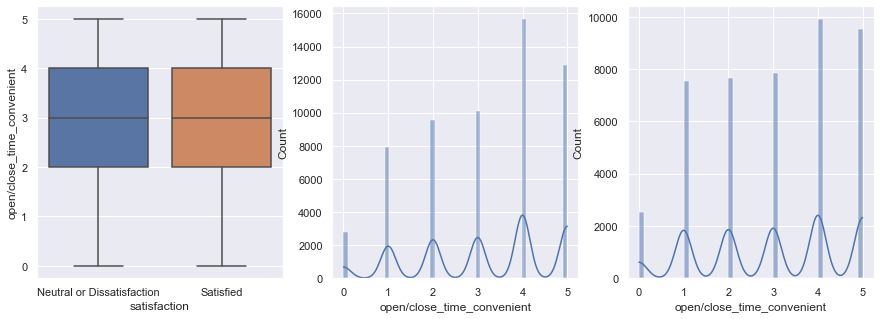

In [36]:
sns.set(rc={'figure.figsize':(15,5)})

# open/close_time_convenient
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='open/close_time_convenient')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'open/close_time_convenient']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'open/close_time_convenient']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='easy_of_online_shopping', ylabel='Count'>

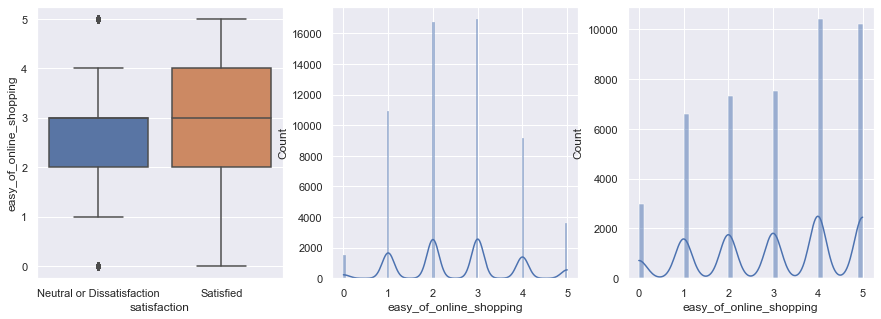

In [37]:
sns.set(rc={'figure.figsize':(15,5)})

# easy_of_online_shopping
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='easy_of_online_shopping')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'easy_of_online_shopping']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'easy_of_online_shopping']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='store_location', ylabel='Count'>

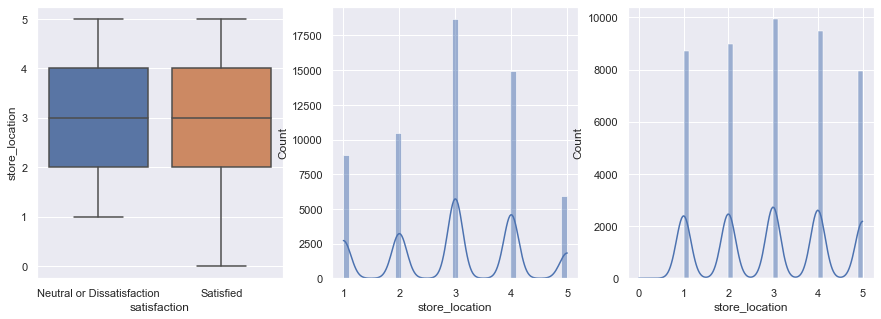

In [38]:
sns.set(rc={'figure.figsize':(15,5)})

# store_location
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='store_location')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'store_location']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'store_location']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='toilet_cleaning', ylabel='Count'>

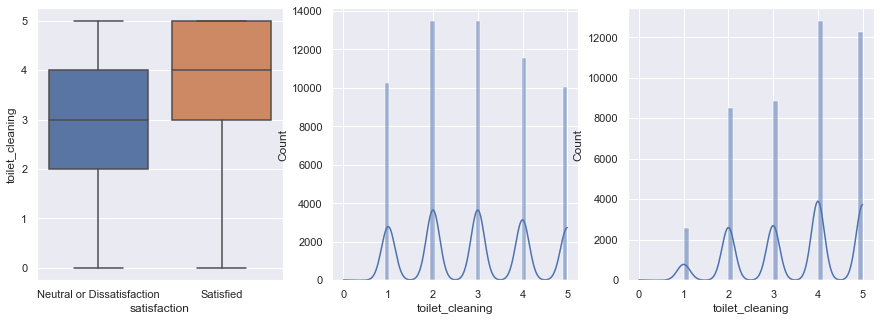

In [39]:
sns.set(rc={'figure.figsize':(15,5)})

# age
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='toilet_cleaning')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'toilet_cleaning']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'toilet_cleaning']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='dressing_room', ylabel='Count'>

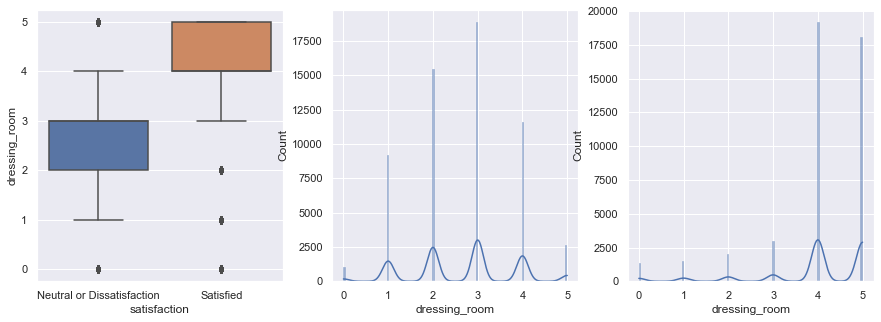

In [40]:
sns.set(rc={'figure.figsize':(15,5)})

# dressing_room
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='dressing_room')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'dressing_room']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'dressing_room']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='waiting_room', ylabel='Count'>

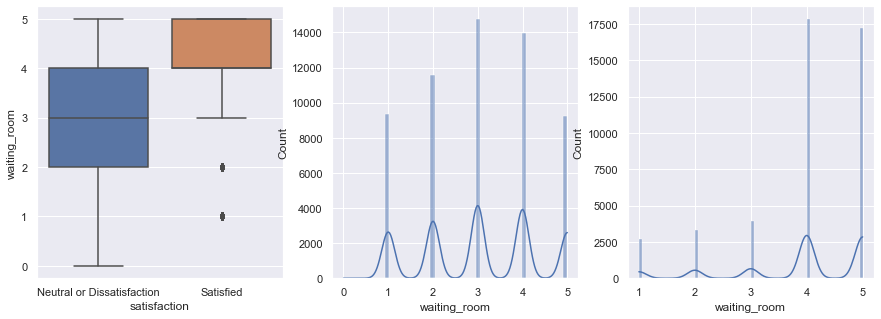

In [41]:
sns.set(rc={'figure.figsize':(15,5)})

# waiting_room
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='waiting_room')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'waiting_room']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'waiting_room']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='kids_entertainment', ylabel='Count'>

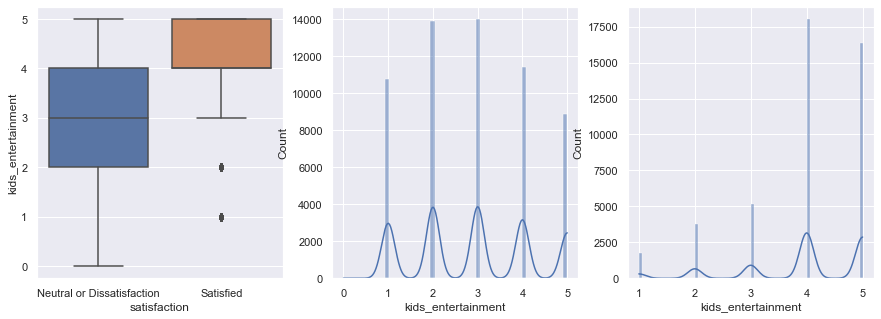

In [42]:
sns.set(rc={'figure.figsize':(15,5)})

# kids_entertainment
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='kids_entertainment')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'kids_entertainment']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'kids_entertainment']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='seller_service', ylabel='Count'>

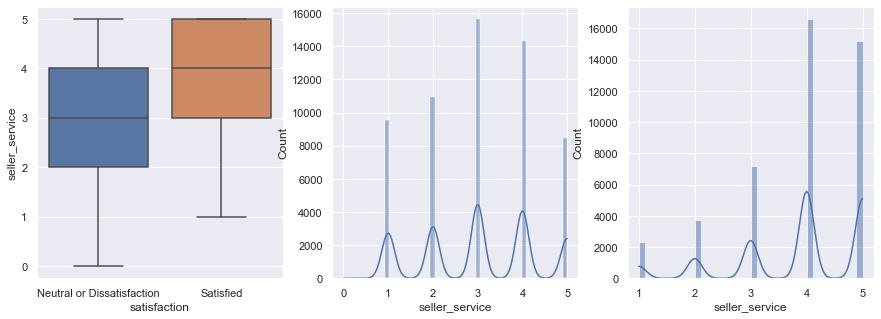

In [43]:
sns.set(rc={'figure.figsize':(15,5)})

# seller_service
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='seller_service')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'seller_service']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'seller_service']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='showroom', ylabel='Count'>

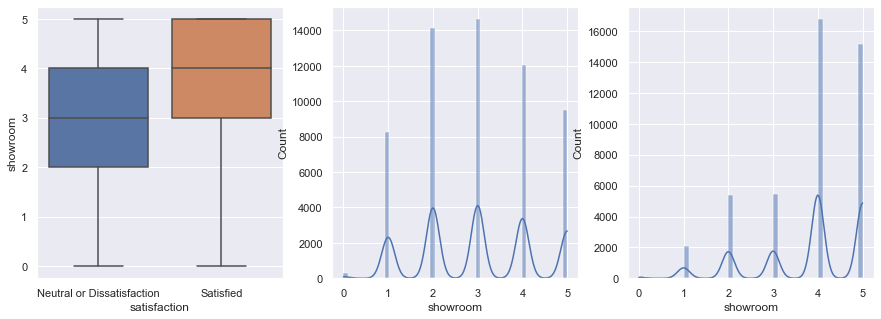

In [44]:
sns.set(rc={'figure.figsize':(15,5)})

# showroom
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='showroom')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'showroom']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'showroom']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='self_store', ylabel='Count'>

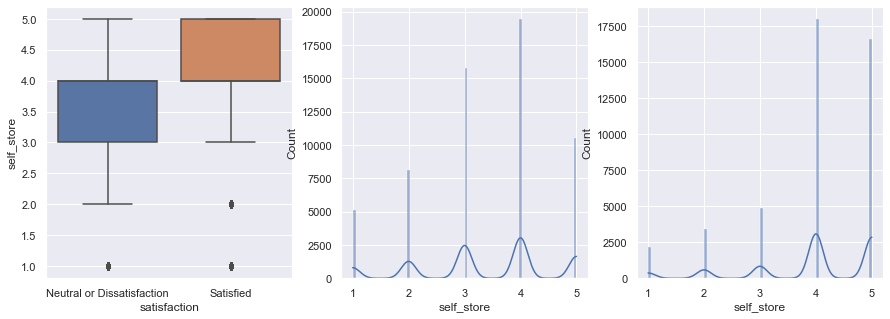

In [45]:
sns.set(rc={'figure.figsize':(15,5)})

# self_store
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='self_store')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'self_store']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'self_store']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='purchase_service', ylabel='Count'>

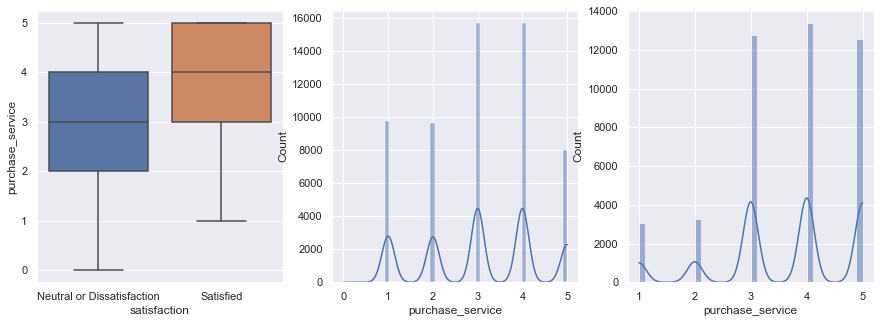

In [46]:
sns.set(rc={'figure.figsize':(15,5)})

# purchase_service
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='purchase_service')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'purchase_service']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'purchase_service']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='store_service', ylabel='Count'>

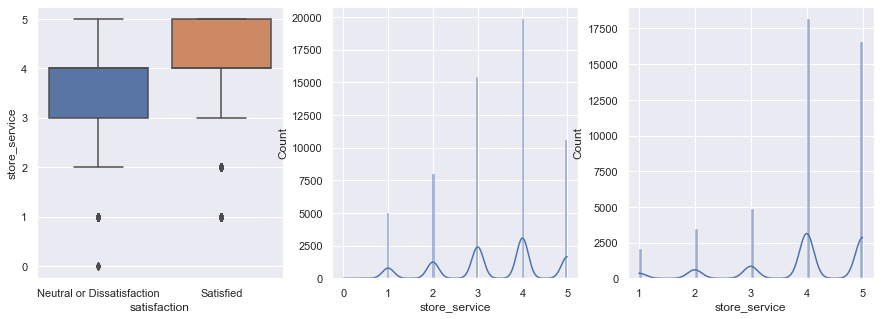

In [47]:
sns.set(rc={'figure.figsize':(15,5)})

# store_service
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='store_service')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'store_service']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'store_service']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='cleanliness', ylabel='Count'>

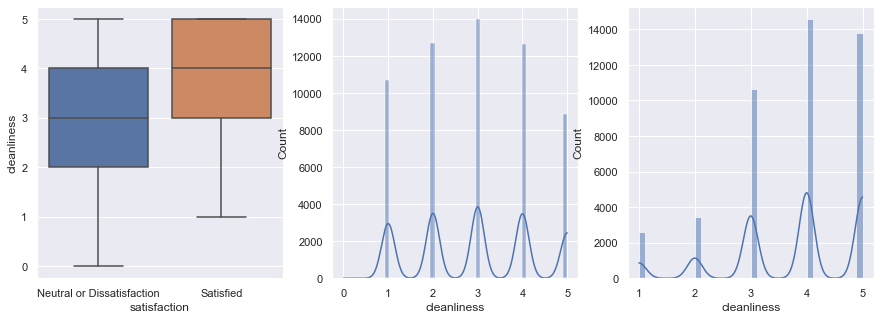

In [48]:
sns.set(rc={'figure.figsize':(15,5)})

# cleanliness
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='cleanliness')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'cleanliness']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'cleanliness']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='carrier_delay_in_minutes', ylabel='Count'>

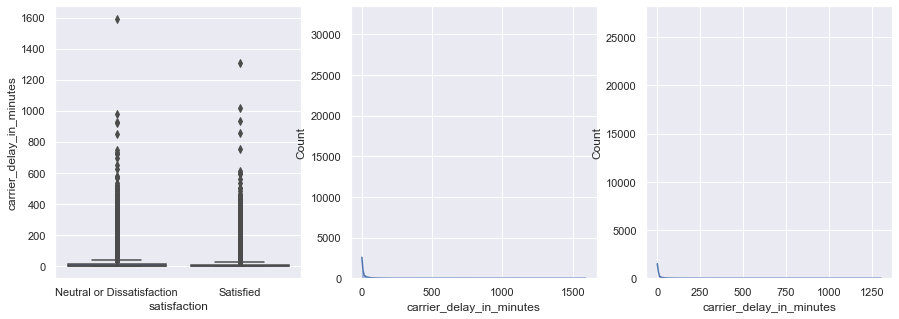

In [49]:
sns.set(rc={'figure.figsize':(15,5)})

# carrier_delay_in_minutes
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='carrier_delay_in_minutes')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'carrier_delay_in_minutes']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'carrier_delay_in_minutes']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='delivery_delay_in_minutes', ylabel='Count'>

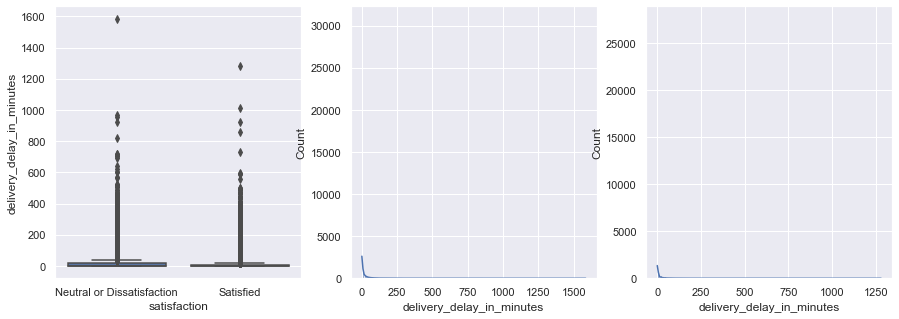

In [50]:
sns.set(rc={'figure.figsize':(15,5)})

# delivery_delay_in_minutes
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='delivery_delay_in_minutes')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'delivery_delay_in_minutes']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'delivery_delay_in_minutes']
sns.histplot(aux1, kde=True)

<AxesSubplot:xlabel='online_purchase', ylabel='Count'>

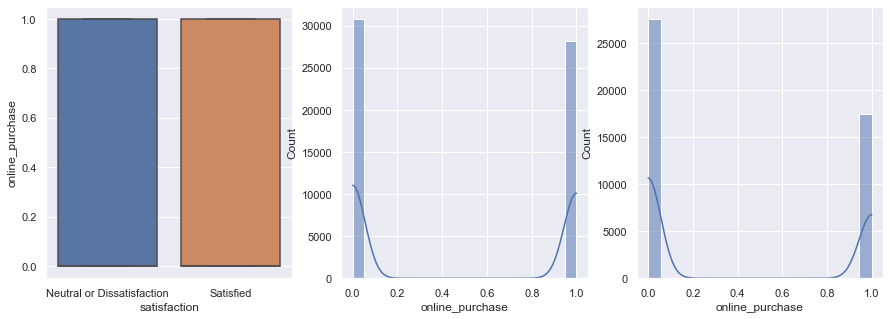

In [51]:
sns.set(rc={'figure.figsize':(15,5)})

# Online Purchase
plt.subplot(1, 3, 1)
sns.boxplot(data=df4, x='satisfaction', y='online_purchase')

plt.subplot(1, 3, 2)
aux1 = df4.loc[df4['satisfaction'] == 'Neutral or Dissatisfaction', 'online_purchase']
sns.histplot(aux1, kde=True)

plt.subplot(1, 3, 3)
aux1 = df4.loc[df4['satisfaction'] == 'Satisfied', 'online_purchase']
sns.histplot(aux1, kde=True)

In [52]:
# Wifi
# easy_of_online_shopping
# toilet_cleaning
# dressing_room
# waiting_room
# kids_entertainment
# seller_service
# showroom
# cleanliness

### 4.2.2 Categorical

In [53]:
df_cat.head()

,gender,customer_type,type_of_purchase,store_size,satisfaction
0,Male,Loyal Customer,Personal,Small,Neutral or Dissatisfaction
1,Male,disloyal Customer,Gift,Large,Neutral or Dissatisfaction
2,Female,Loyal Customer,Gift,Large,Satisfied
3,Female,Loyal Customer,Gift,Large,Neutral or Dissatisfaction
4,Male,Loyal Customer,Gift,Large,Satisfied


<AxesSubplot:xlabel='store_size', ylabel='count'>

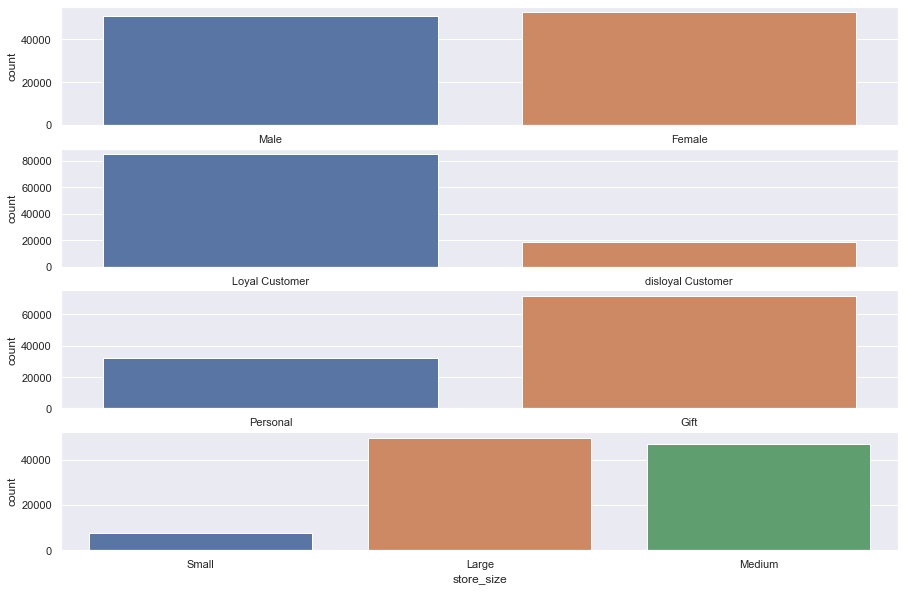

In [54]:
sns.set(rc={'figure.figsize':(15,10)})

# gender
aux1 = df4[['gender', 'satisfaction']]

plt.subplot(4, 1, 1)
sns.countplot(x='gender', data=aux1)

# customer_type
aux1 = df4[['customer_type', 'satisfaction']]

plt.subplot(4, 1, 2)
sns.countplot(x='customer_type', data=aux1)

# type_of_purchase
aux1 = df4[['type_of_purchase', 'satisfaction']]

plt.subplot(4, 1, 3)
sns.countplot(x='type_of_purchase', data=aux1)

# store_size
aux1 = df4[['store_size', 'satisfaction']]

plt.subplot(4, 1, 4)
sns.countplot(x='store_size', data=aux1)

# 5. Data Preparation

In [55]:
df5 = df4.copy()

## 5.1 Rescalling

In [56]:
rs = RobustScaler()

# Store Distance
df5['store_distance'] = rs.fit_transform(df5[['store_distance']].values)

# carrier_delay_in_minutes
df5['carrier_delay_in_minutes'] = rs.fit_transform(df5[['carrier_delay_in_minutes']].values)

# delivery_delay_in_minutes
df5['delivery_delay_in_minutes'] = rs.fit_transform(df5[['delivery_delay_in_minutes']].values) 

## 5.2 Transforming

### 5.2.1 Encoding

In [57]:
le = LabelEncoder()

# gender
df5['gender'] = le.fit_transform(df5['gender'])

# customer_type
df5['customer_type'] = le.fit_transform(df5['customer_type'])

# Satisfaction
df5['satisfaction'] = le.fit_transform(df5['satisfaction'])

# One-Hot Encoding

# type_of_purchase
df5 = pd.get_dummies(df5, prefix=['type_of_purchase'], columns=['type_of_purchase'])

# store_size
df5 = pd.get_dummies(df5, prefix=['store_size'], columns=['store_size'])

# online_purchase
df5 = pd.get_dummies(df5, prefix=['online_purchase'], columns=['online_purchase'])

# 6. Feature Selection

In [107]:
df6 = df5.copy()

In [110]:
X_train = df6.drop(columns=['id', 'satisfaction'])
y_train = df6['satisfaction']

## 6.1 Random Forest Feature Selection

In [111]:
# Random Forest Classifier model
rfc = RandomForestClassifier(criterion='gini', min_samples_split=10)

# Train
rfc.fit(X_train, y_train)

# Feature Selection - Elapsed Date
rfc_importances = rfc.feature_importances_

In [112]:
pd.DataFrame(list(zip(X_train.columns.tolist(), rfc_importances))).sort_values(by=1, ascending=False).T

,6,3,17,8,18,15,16,0,7,4,10,1,14,2,12,11,13,9,5
0,dressing_room,in_store_wifi,store_size_Large,kids_entertainment,store_size_Medium,type_of_purchase_Gift,type_of_purchase_Personal,customer_type,waiting_room,easy_of_online_shopping,showroom,age,cleanliness,store_distance,purchase_service,self_store,store_service,seller_service,store_location
1,0.183223,0.165735,0.07065,0.066772,0.060448,0.059711,0.055789,0.04553,0.042245,0.039796,0.027612,0.025346,0.024675,0.024395,0.023716,0.023322,0.022838,0.022596,0.015599


## 6.2 Drop Columns

In [108]:
df6 = df6.drop(columns=['toilet_cleaning', 'delivery_delay_in_minutes', 'carrier_delay_in_minutes', 'gender',
  'store_size_Small', 'online_purchase_0', 'online_purchase_1', 'open/close_time_convenient'])

In [109]:
df6.head()

,id,customer_type,age,store_distance,in_store_wifi,easy_of_online_shopping,store_location,dressing_room,waiting_room,kids_entertainment,...,showroom,self_store,purchase_service,store_service,cleanliness,satisfaction,type_of_purchase_Gift,type_of_purchase_Personal,store_size_Large,store_size_Medium
0,70172,0,13,-0.288187,3,3,1,3,5,5,...,3,4,4,5,5,0,0,1,0,0
1,5047,1,25,-0.457487,3,3,3,3,1,1,...,5,3,1,4,1,0,1,0,1,0
2,110028,0,26,0.224981,2,2,2,5,5,5,...,3,4,4,4,5,1,1,0,1,0
3,24026,0,25,-0.211437,2,5,5,2,2,2,...,5,3,1,4,2,0,1,0,1,0
4,119299,0,61,-0.473288,3,3,3,5,5,3,...,4,4,3,3,3,1,1,0,1,0


## 6.1 Split DataSet

In [113]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Train-validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# 7. Machine Learning Modeling

## 7.1 Random Forest Classifier

### 7.1.1 Train

In [114]:
# model
rfc_model = RandomForestClassifier()

# Train
rfc_model.fit(X_train, y_train)

# Predict
y_hat_rfc = rfc_model.predict_proba(X_val)

### 7.1.2 Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Threshold: 0.41, Accuracy Score: 0.9315


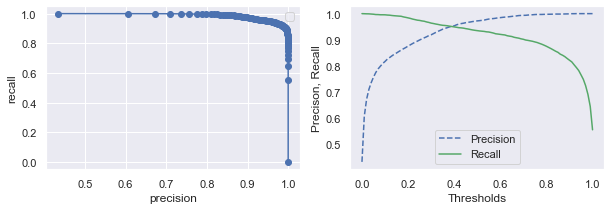

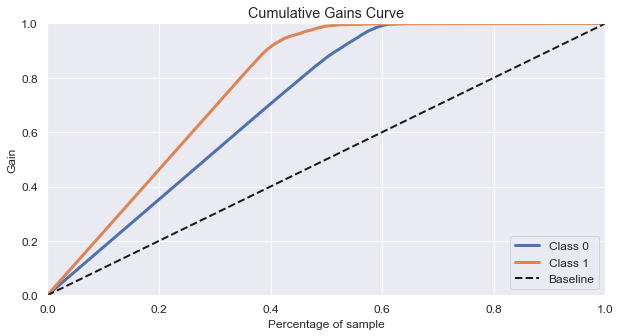

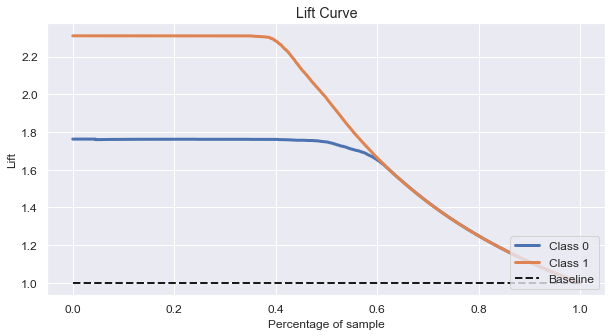

In [115]:
metrics(y_val, y_hat_rfc)

## 7.2 XGB Classifier

### 7.2.1 Train

In [116]:
# model
xgb_model = XGBClassifier()

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_hat_xgb = xgb_model.predict_proba(X_val)

### 7.2.2 Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Threshold: 0.3980948328971863, Accuracy Score: 0.9330


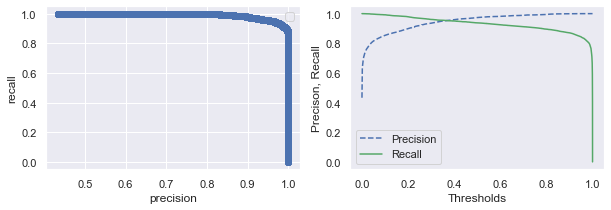

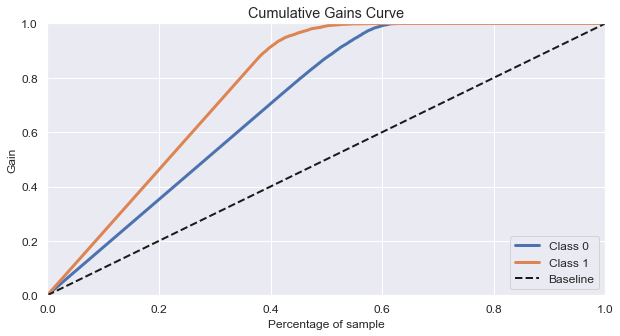

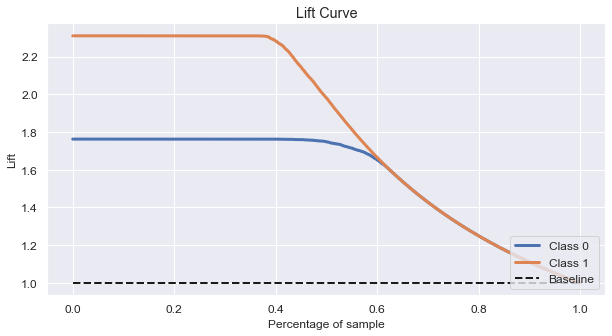

In [117]:
metrics(y_val, y_hat_xgb)

## 7.3 Decision Tree Classifier

### 7.3.1 Train

In [118]:
# model
dtc_model = DecisionTreeClassifier()

# Train
dtc_model.fit(X_train, y_train)

# Predict
y_hat_dtc = dtc_model.predict_proba(X_val)

### 7.3.2 Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Threshold: 1.0, Accuracy Score: 0.4327


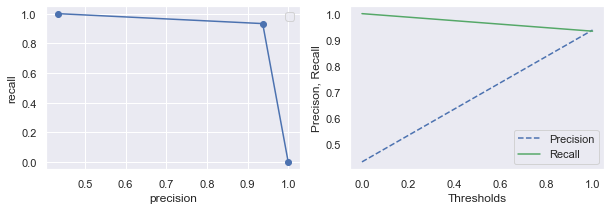

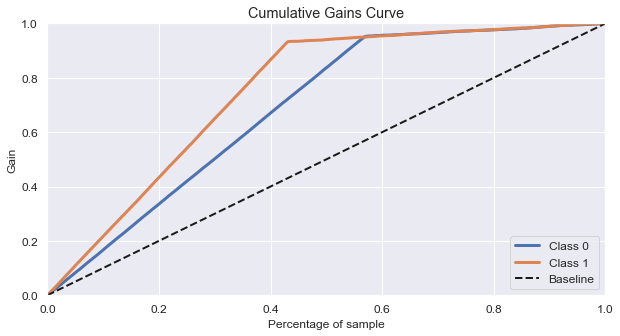

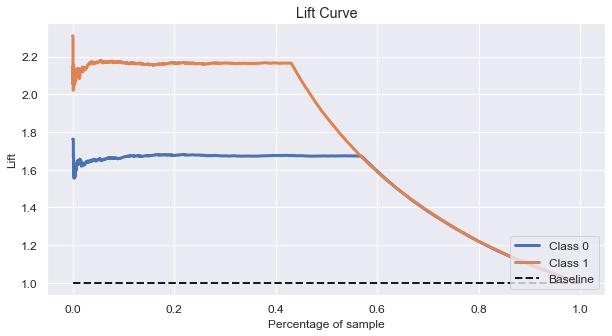

In [119]:
metrics(y_val, y_hat_dtc)

## 7.4 KNC - K-Neighbors Classifier

### 7.4.1 Train

In [120]:
# model
knc_model = KNeighborsClassifier()

# Train
knc_model.fit(X_train, y_train)

# Predict
y_hat_knc = knc_model.predict_proba(X_val)

### 7.4.2 Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Threshold: 0.4, Accuracy Score: 0.8737


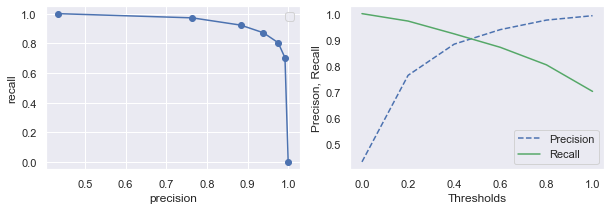

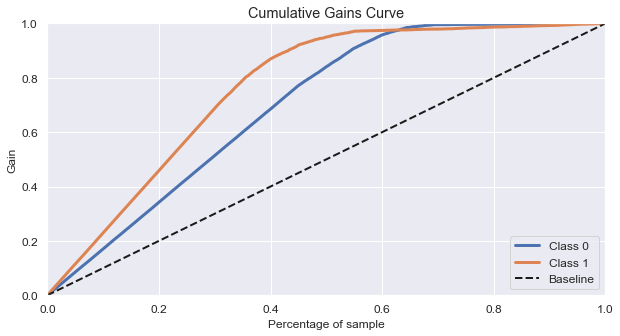

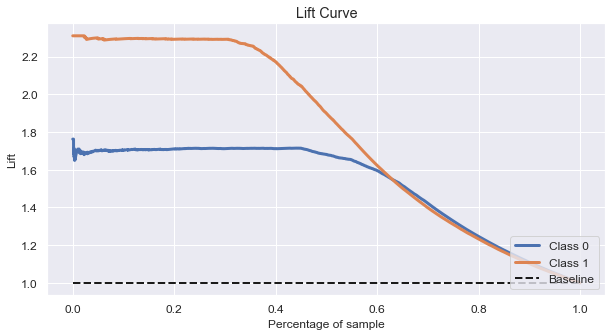

In [121]:
metrics(y_val, y_hat_knc)

## 7.5 SVM - Suport Vector Machine

### 7.5.1 Train

In [122]:
# model
svm_model = LinearSVC()

# Train
svm_model.fit(X_train, y_train)

# Predict
y_hat_svm = svm_model.predict(X_val)

D:\Users\gtvmi\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### 7.5.2 Evaluation

In [123]:
y_hat_svm_new = np.column_stack((y_hat_svm, y_hat_svm))
y_hat_svm_new

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [1, 1],
       [0, 0],
       [0, 0]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Threshold: 1, Accuracy Score: 0.4327


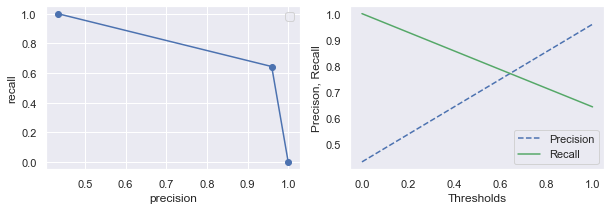

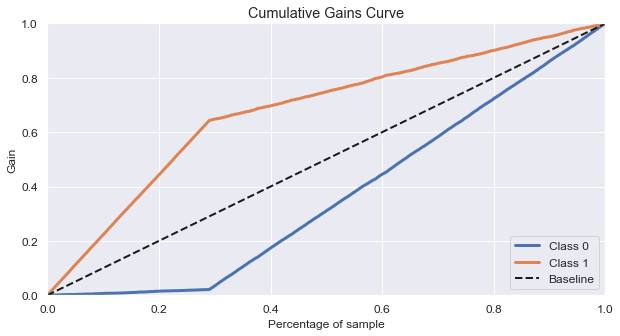

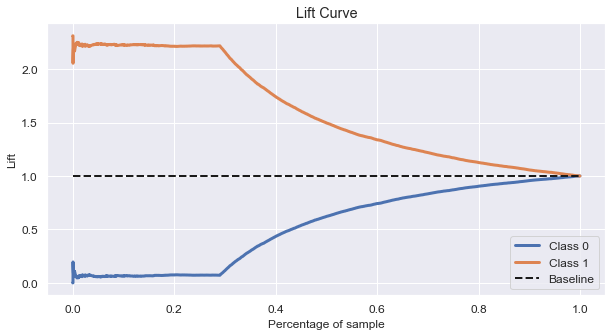

In [124]:
metrics(y_val, y_hat_svm_new)

## 7.6 Naive Bayes - GausianNB

### 7.6.1 Train

In [125]:
# model
gnb_model = GaussianNB()

# Train
gnb_model.fit(X_train, y_train)

# Predict
y_hat_gnb = gnb_model.predict_proba(X_val)

### 7.6.2 Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Threshold: 0.5063099013958104, Accuracy Score: 0.7706


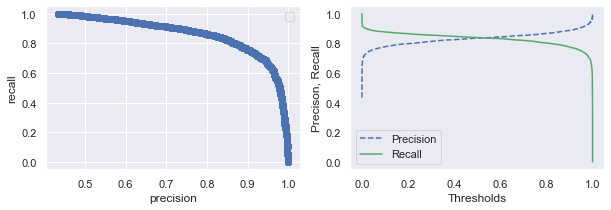

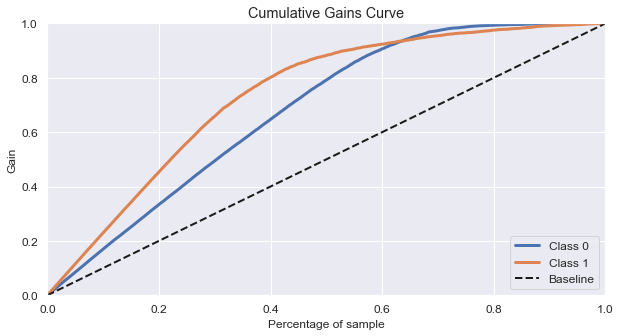

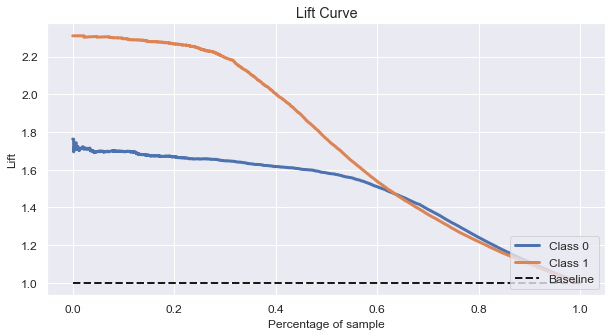

In [126]:
metrics(y_val, y_hat_gnb)

## 7.7 Parcial Accuracy
	Todas as colunas -> seleção das colunas

- Random Forest Classifier
	- 0.9248 -> 0.9315
- XGB Classifier
	- 0.9387 -> 0.9330
- Decision Tree Classifier
	- 0.4327 -> 0.4327
- KNC - K-Neighbors Classifier
	- 0.8586 -> 8737
- SVM - Suport Vector Machine
	- 0.4327 -> 0.4327
- Naive Bayes - GausianNB
	- 0.7682 -> 0.7706

# 8. Hyperparameter Fine Tunning

## 8.1 Concat Train-Validation
A ideia aqui é voltar a concatenar novamente os treino e validação para aumentar a base de dados para treino.

In [127]:
X_train_hft = pd.concat([X_train, X_val], ignore_index=True)
y_train_hft = pd.concat([y_train, y_val], ignore_index=True)

## 8.2 XGB Classifier

### 8.2.1 Random Search

In [156]:
param = {
        'n_estimators' : [10, 50, 100, 150, 200],
        'max_depth' : [4, 8, 12, 15, 20, 25, 30],
        'max_leaves' : [0],
        'grow_policy' : ['depthwise', 'lossguide'],
        'learning_rate' : [0.10, 0.12, 0.15, 0.17, 0.2, 0.25],
        'booster' : ['gbtree', 'gblinear', 'dart'],
        'tree_method' : ['auto'],
        'n_jobs' : [1]
        }

MAX_EVAL = 10

In [159]:
param = {
        'n_estimators' : [100],
        'max_depth' : [6],
        'max_leaves' : [0],
        'grow_policy' : ['depthwise'],
        'learning_rate' : [0.3],
        'booster' : ['gbtree'],
        'tree_method' : ['auto'],
        'n_jobs' : [1]
        }

MAX_EVAL = 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'n_estimators': 100, 'max_depth': 6, 'max_leaves': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.3, 'booster': 'gbtree', 'tree_method': 'auto', 'n_jobs': 1}
Best Threshold: 1.0, Accuracy Score: 0.4327


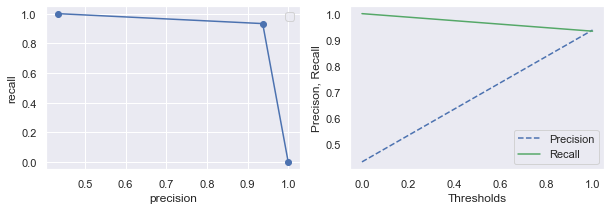

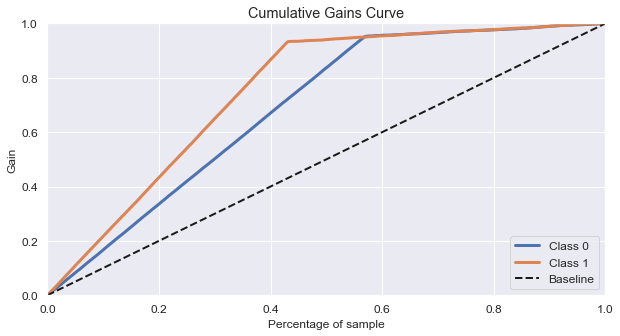

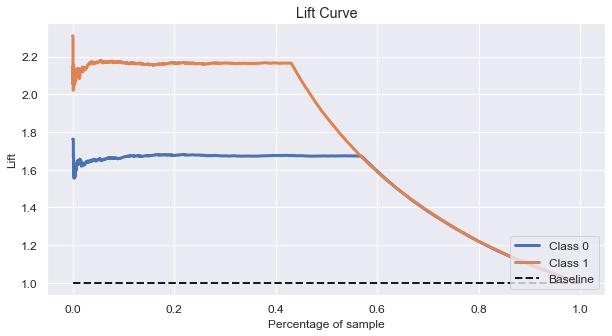

In [162]:
for i in range(MAX_EVAL):
    # Choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    
    # Model
    xgb_model_s = XGBClassifier(n_estimators  = hp['n_estimators'],
                                max_depth     = hp['max_depth'],
                                max_leaves    = hp['max_leaves'],
                                grow_policy   = hp['grow_policy'],
                                learning_rate = hp['learning_rate'],
                                booster       = hp['booster'],
                                tree_method   = hp['tree_method'],
                                n_jobs        = hp['n_jobs'])
    
    #Train
    xgb_model_s.fit(X_train, y_train)
    
    # Performace
    yhat_val = dtc_model.predict_proba(X_val)
    
    print(hp)
    metrics(y_val, yhat_val)

### 8.2.2 Final XGB Model

#### 8.2.2.1 Train

In [128]:
# model
xgbclassifier_model = XGBClassifier()

# Train
xgbclassifier_model.fit(X_train_hft, y_train_hft)

# Predict
y_hat_xgbclassifier = xgbclassifier_model.predict_proba(X_test)

#### 8.2.2.2 Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Threshold: 0.4087691307067871, Accuracy Score: 0.9344


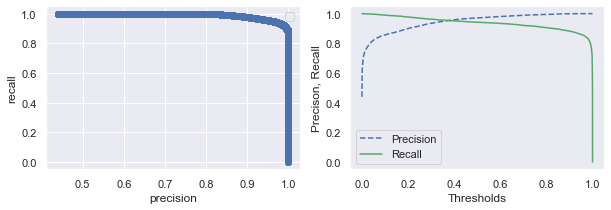

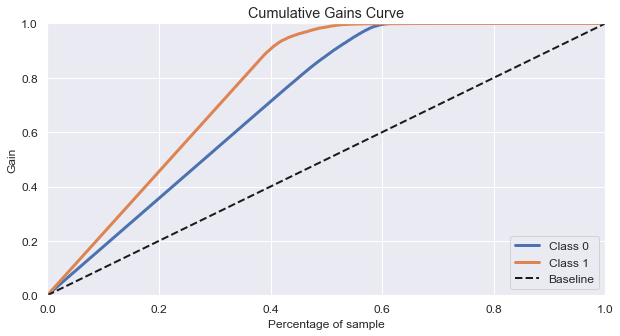

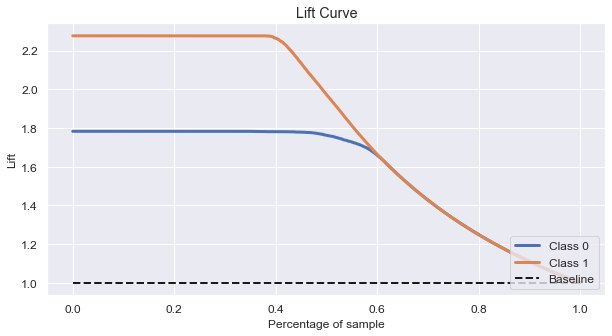

In [129]:
metrics(y_test, y_hat_xgbclassifier)

# 9. Response

In [131]:
df9 = df_raw_test.copy()

## 9.1 Cicle

In [132]:
# Rename Columns
new_columns = ['id', 'gender', 'customer_type', 'age', 'type_of_purchase',
               'store_size', 'store_distance', 'in_store_wifi',
               'open/close_time_convenient', 'easy_of_online_shopping',
               'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
               'kids_entertainment', 'seller_service', 'showroom', 'self_store',
               'purchase_service', 'store_service', 'cleanliness',
               'carrier_delay_in_minutes', 'delivery_delay_in_minutes']
df9.columns = new_columns

# Fillout na
med = np.round(df1['delivery_delay_in_minutes'].mean())
df9['delivery_delay_in_minutes'] = df9.apply(lambda x: 
                                            x['delivery_delay_in_minutes'] if pd.notna(x['delivery_delay_in_minutes']) else
                                            0 if x['carrier_delay_in_minutes'] == 0 else med, axis = 1)

# Feature Engineering

# Online/in person purchase
df9['online_purchase'] = df9['delivery_delay_in_minutes'].apply(lambda x: 0 if x == 0 else 1 )

# Rescaling
rs = RobustScaler()

# Store Distance
df9['store_distance'] = rs.fit_transform(df9[['store_distance']].values)

# carrier_delay_in_minutes
df9['carrier_delay_in_minutes'] = rs.fit_transform(df9[['carrier_delay_in_minutes']].values)

# delivery_delay_in_minutes
df9['delivery_delay_in_minutes'] = rs.fit_transform(df9[['delivery_delay_in_minutes']].values) 

# Encoding

le = LabelEncoder()

# gender
df9['gender'] = le.fit_transform(df9['gender'])

# customer_type
df9['customer_type'] = le.fit_transform(df9['customer_type'])

# One-Hot Encoding

# type_of_purchase
df9 = pd.get_dummies(df9, prefix=['type_of_purchase'], columns=['type_of_purchase'])

# store_size
df9 = pd.get_dummies(df9, prefix=['store_size'], columns=['store_size'])

# online_purchase
df9 = pd.get_dummies(df9, prefix=['online_purchase'], columns=['online_purchase'])

## 9.2 Response Predict

In [134]:
# Data select
cols = ['id', 'toilet_cleaning', 'delivery_delay_in_minutes', 'carrier_delay_in_minutes', 'gender',
  'store_size_Small', 'online_purchase_0', 'online_purchase_1', 'open/close_time_convenient']

X_df9 = df9.drop(columns=cols)

# Predict
y_hat_final = xgbclassifier_model.predict_proba(X_df9)

In [135]:
df9['Satisfaction'] = y_hat_final[:,1]

In [136]:
df9['Satisfaction'] = df9['Satisfaction'].apply(lambda x: 1 if x > 0.4 else 0)

## 9.3 Response Submit

In [137]:
df_sub = pd.read_csv('dataset/submission.csv', sep=';')
df_sub.head()

,id,Satisfaction
0,19556,1
1,90035,1
2,12360,1
3,77959,0
4,36875,0


In [138]:
df_sub = df9[['id', 'Satisfaction']]
df_sub.to_csv('dataset/sub5.csv', index=False)